# Experiment 7:
## Reconstruction with dithering, CIFAR-10

This experiment shows the behaviour of the regularized reconstruction method with dithering on the CIFAR-10 data set for various structural assumptions:
- Sparsity in per colour channel single level 2D Haar wavelets and
- Generative model.

In [1]:
import numpy as np;
import numpy.linalg as linalg;

import matplotlib.pyplot as plt;

import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torch.optim as optim;

import pywt;

from torch.utils.data import DataLoader;
import torchvision;
import torchvision.transforms as transforms;

from torch.autograd import Variable;

import pickle;
import time;
import random;
import math;

from IPython.display import clear_output;
from PIL import Image

import os;

import CIFAR10_utils as CIFAR;
import CIFAR10_generative as generative;
import sparsity_utils as sparsity;
import general_utils as utils;

# Initialization

In [2]:
(train_data, test_data), (train_loader, test_loader) = CIFAR.load_dataset();

noise = 0.1;
mspace_haar = np.linspace(1, 50000, 3, dtype='int'); #30
mspace_gen =  np.linspace(1, 20000, 3, dtype='int');

repetitions = 1; #3

lamb = 60;

Files already downloaded and verified
Files already downloaded and verified


# Haar wavelet

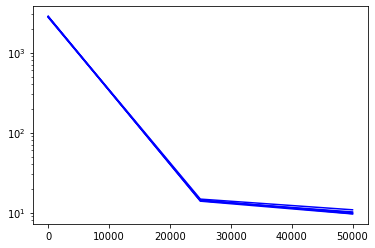

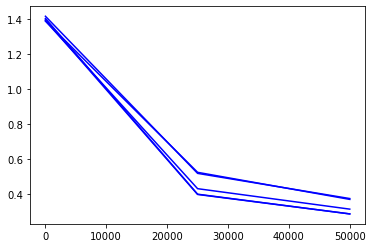

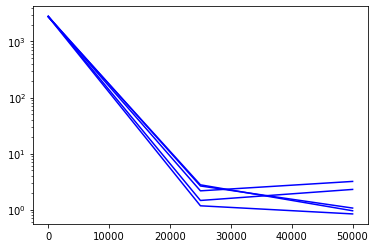

In [8]:
results_haar = [len(mspace_haar)*[0] for i in range(5)];
results_haar_normerr = [len(mspace_haar)*[0] for i in range(5)];
results_haar_raderr = [len(mspace_haar)*[0] for i in range(5)];

projector = lambda x : sparsity.HT_transform(x, 800, sparsity.haar2d_3channel, sparsity.inverse_haar2d_3channel)

utils.reset_seeds();
for i in range(5):
    x_true = CIFAR.getImageAsVector(test_loader, i);
    true_rad = linalg.norm(x_true);
    
    for j in range(len(mspace_haar)):
        m = mspace_haar[j];
        
        accum = 0.0;
        accum_normerr = 0.0;
        accum_raderr = 0.0;
        for k in range(repetitions):
            A = None;
            A, q = utils.generateMeasurements_Gaussian_dithering(x_true, m, noise, lamb);      
            y, acc, _ = CIFAR.reconstruct_regularized_dithering(A, q, lamb, x_true, projector, learning_param = 0.2, iterations = 50);
            accum += acc;
            accum_normerr += utils.normelized_error(x_true, y);
            accum_raderr += abs(true_rad - linalg.norm(y));
        results_haar[i][j] = accum/repetitions;
        results_haar_normerr[i][j] = accum_normerr/repetitions;
        results_haar_raderr[i][j] = accum_raderr/repetitions;
    
    clear_output(wait=True);
    for k in range(i+1):
        plt.yscale('log');
        plt.plot(mspace_haar, results_haar[k], c='b');
    plt.show();
    for k in range(i+1):
        plt.yscale('linear');
        plt.plot(mspace_haar, results_haar_normerr[k], c='b');
    plt.show();
    for k in range(i+1):
        plt.yscale('log');
        plt.plot(mspace_haar, results_haar_raderr[k], c='b');
    plt.show();

In [9]:
utils.saveData((results_haar, results_haar_normerr, results_haar_raderr), "results_data/10_haar.dat");

In [10]:
(results_haar, results_haar_normerr, results_haar_raderr) = utils.loadData("results_data/10_haar.dat");

# Generative

In [3]:
utils.reset_seeds();
autoEncoder = generative.createNetwork();
generative.trainNetwork(autoEncoder, train_loader);

projector = lambda x : generative.project(x, autoEncoder , num_epochs = 50, learning_rate = 0.001);

[1,  2000] loss: 0.596
[2,  2000] loss: 0.580
[3,  2000] loss: 0.570
[4,  2000] loss: 0.568
[5,  2000] loss: 0.568
[6,  2000] loss: 0.567
[7,  2000] loss: 0.567
[8,  2000] loss: 0.567
[9,  2000] loss: 0.566
[10,  2000] loss: 0.566


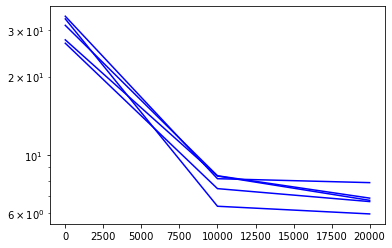

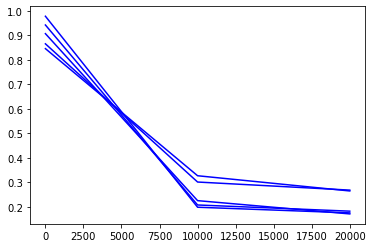

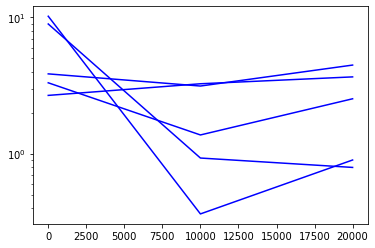

In [6]:
results_gen = [len(mspace_gen)*[0] for i in range(5)]
results_gen_normerr = [len(mspace_gen)*[0] for i in range(5)];
results_gen_raderr = [len(mspace_gen)*[0] for i in range(5)];

utils.reset_seeds();
for i in range(5):
    x_true = CIFAR.getImageAsVector(test_loader, i);
    true_rad = linalg.norm(x_true);
    
    for j in range(len(mspace_gen)):
        m = mspace_gen[j];
        
        accum = 0.0;
        accum_normerr = 0.0;
        accum_raderr = 0.0;
        for k in range(repetitions):
            A = None;
            A, q = utils.generateMeasurements_Gaussian_dithering(x_true, m, noise, lamb);      
            y, acc, _ = CIFAR.reconstruct_regularized_dithering(A, q, lamb, x_true, projector, learning_param = 0.2, iterations = 50);
            accum += acc;
            accum_normerr += utils.normelized_error(x_true, y);
            accum_raderr += abs(true_rad - linalg.norm(y));
        results_gen[i][j] = accum/repetitions;
        results_gen_normerr[i][j] = accum_normerr/repetitions;
        results_gen_raderr[i][j] = accum_raderr/repetitions;
    
    clear_output(wait=True);
    for k in range(i+1):
        plt.yscale('log');
        plt.plot(mspace_gen, results_gen[k], c='b');
    plt.show();
    for k in range(i+1):
        plt.yscale('linear');
        plt.plot(mspace_gen, results_gen_normerr[k], c='b');
    plt.show();
    for k in range(i+1):
        plt.yscale('log');
        plt.plot(mspace_gen, results_gen_raderr[k], c='b');
    plt.show();

In [7]:
utils.saveData((results_gen, results_gen_normerr, results_gen_raderr), "results_data/7_gen.dat");

In [8]:
(results_gen, results_gen_normerr, results_gen_raderr) = utils.loadData("results_data/7_gen.dat");

# Processing

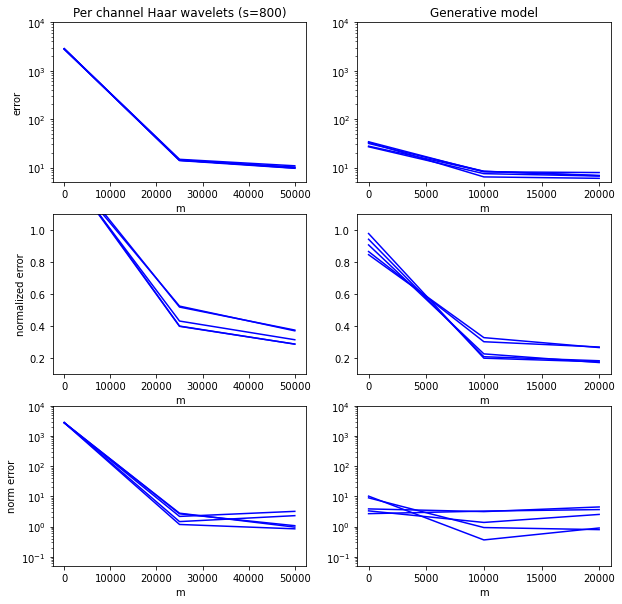

In [13]:
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(321)
ax2 = f.add_subplot(322)

ax3 = f.add_subplot(323)
ax4 = f.add_subplot(324)

ax5 = f.add_subplot(325)
ax6 = f.add_subplot(326)

ax1.set_yscale('log');
for i in range(5):
    ax1.plot(mspace_haar, results_haar[i], 'b');
ax1.set_title("Per channel Haar wavelets (s=800)");
ax1.set_xlabel("m");
ax1.set_ylabel("error");
ax1.set_ylim([5,10000]);

ax2.set_yscale('log');
for i in range(5):
    ax2.plot(mspace_gen, results_gen[i], 'b');
ax2.set_title("Generative model"); 
ax2.set_xlabel("m");
ax2.set_ylim([5,10000]);


for i in range(5):
    ax3.plot(mspace_haar, results_haar_normerr[i], 'b');
ax3.set_xlabel("m");
ax3.set_ylabel("normalized error");
ax3.set_ylim([0.1,1.1]);

for i in range(5):
    ax4.plot(mspace_gen, results_gen_normerr[i], 'b');
ax4.set_xlabel("m");
ax4.set_ylim([0.1,1.1]);


ax5.set_yscale('log');
for i in range(5):
    ax5.plot(mspace_haar, results_haar_raderr[i], 'b');
ax5.set_xlabel("m");
ax5.set_ylabel("norm error");
ax5.set_ylim([0.05,10000]);

ax6.set_yscale('log');
for i in range(5):
    ax6.plot(mspace_gen, results_gen_raderr[i], 'b');
ax6.set_xlabel("m");
ax6.set_ylim([0.05,10000]);

f.savefig("results_images/Cifar_comparison.png", dpi=300);